# Importacion de librerias

In [2]:
import numpy as np
import skrf as rf
import pandas as pd
import matplotlib.pyplot as plt
import re
import os

## Definicion de funcion 

In [3]:
def calculos(f, S_11, S_12, S_21, S_22):
    
    
    Zo = 50
    
    #Calculo de estabilidad
    Delta = S_11*S_22 - S_12*S_21
    K = (1 - np.abs(S_11)**2 - np.abs(S_22)**2 + np.abs(Delta)**2)/(2*np.abs(S_12*S_21))
    
    if K < 1:
        return None
    
    # Calculo de coeficientes 
    B1 = 1 + np.abs(S_11)**2 - np.abs(S_22)**2 - np.abs(Delta)**2
    B2 = 1 + np.abs(S_22)**2 - np.abs(S_11)**2 - np.abs(Delta)**2
    C1 = S_11 - Delta*np.conj(S_22)
    C2 = S_22 - Delta*np.conj(S_11)
    
    C1_mod = np.abs(C1)
    C1_fase = np.angle(C1)
    C2_mod = np.abs(C2)
    C2_fase = np.angle(C2)
    
    # Calculo de reflexiones de entrada y salida
    Gamma_in_fase = C1_fase
    
    if B1 > 0:
        Gamma_in_mod = (B1 - np.sqrt(B1**2 - 4*C1_mod**2))/(2*C1_mod)
    else:
        Gamma_in_mod = (B1 + np.sqrt(B1**2 - 4*C1_mod**2))/(2*C1_mod)
        
    
    Gamma_in = Gamma_in_mod*np.exp(1j*Gamma_in_fase)
    
    
    Gamma_out_fase = C2_fase
    
    if B2 > 0:
        Gamma_out_mod = (B2 - np.sqrt(B2**2 - 4*C2_mod**2))/(2*C2_mod)
    else:
        Gamma_out_mod = (B2 + np.sqrt(B2**2 - 4*C2_mod**2))/(2*C2_mod)
        
    
    Gamma_out = Gamma_out_mod*np.exp(1j*Gamma_out_fase)
    
    Zin = Zo*(1 + Gamma_in)/(1 - Gamma_in)
    Zout = Zo*(1 + Gamma_out)/(1 - Gamma_out)
    
    Zs = np.round(np.conj(Zin),4)
    Zl = np.round(np.conj(Zout),4)
    K = np.round(K,4)

    
    return Zs, Zl, K
    

# Verificacion de ejemplo

In [4]:
f = 2304e6
S11mod = 0.656
S11fase = 146.7
S12mod = 0.122
S12fase = 46.1
S21mod = 2.3
S21fase = 44.7
S22mod = 0.172
S22fase = -117.1

S11 = S11mod*np.exp(1j*np.radians(S11fase))
S12 = S12mod*np.exp(1j*np.radians(S12fase))
S21 = S21mod*np.exp(1j*np.radians(S21fase))
S22 = S22mod*np.exp(1j*np.radians(S22fase))


calculos(f, S11, S12, S21, S22)

((4.3224-13.1334j), (25.5472+56.9023j), 1.071)

## Extraccion de todos los parametros s del BFP450 para una frecuencia de 1.6 GHz

C:\Users\Jeremias\AppData\Local\Temp\ipykernel_112\1513372518.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, values], ignore_index=True)


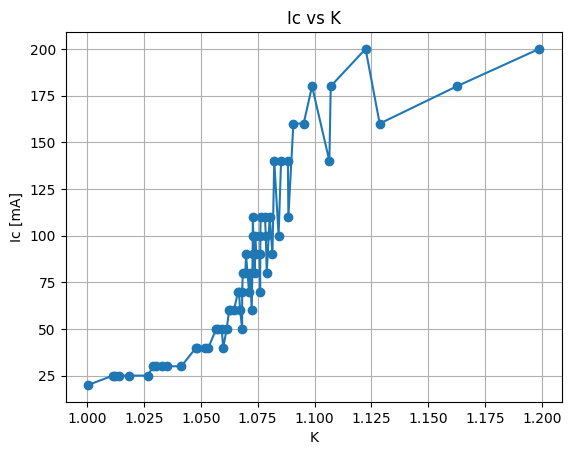

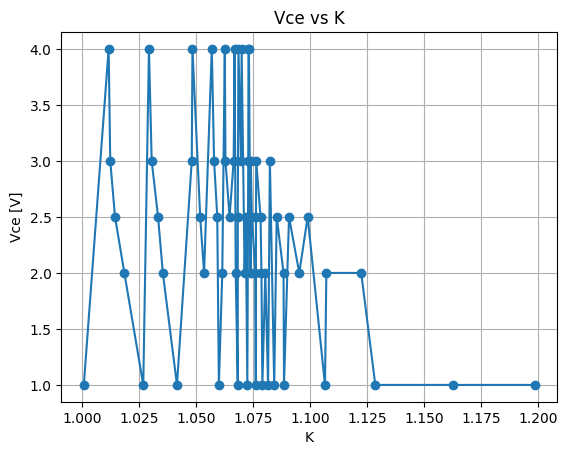

In [5]:
f = 1.6e9 # Frecuencia de 1.6 GHz

# Ruta de la carpeta que contiene los archivos .s2p
archivo = r'C:\Users\Jeremias\Documents\GitHub\TP2-Electronica-Analogica-III\Hoja de datos\BFP 450\Infineon-RFTransistor\SPAR\BFP450/BFP450_w_noise_VCE_'

# Extraccion de valores de Vce e Ic
vce = ['1.0V','2.0V','2.5V','3.0V','4.0V']
ic = ['5.0mA','10mA','15mA','20mA','25mA','30mA','40mA','50mA','60mA','70mA','80mA','90mA','0.10A','0.11A','0.14A','0.16A','0.18A','0.20A']
df = pd.DataFrame(columns=['Vce','Ic','Zs','Zl','K','S11','S12','S21','S22'])

for v in vce:
    for i in ic:
        try:
            str_model = archivo+v+'_IC_'+i+'.s2p'
            model = rf.Network(str_model)
            S11 = model['1.6ghz'].s[0][0][0]
            S12 = model['1.6ghz'].s[0][0][1]
            S21 = model['1.6ghz'].s[0][1][0]
            S22 = model['1.6ghz'].s[0][1][1]
            results = calculos(f, S11, S12, S21, S22)
            if results != None:
                values = pd.DataFrame({'Vce':[v],'Ic':[i],'Zs':[results[0]],'Zl':[results[1]],'K':[results[2]],'S11':[np.round(S11,2)],'S12':[np.round(S12,2)],'S21':[np.round(S21,2)],'S22':[np.round(S22,2)]})
                df = pd.concat([df, values], ignore_index=True)
        except:
            pass


# Ordenar de mayor a menor K
df = df.sort_values('K',ascending=False)
        
# Convertir valores de vce e ic a numeros 
def Corriente2float(x):
    if 'mA' in x:
        return float(x.replace('mA',''))
    else:
        return float(x.replace('A',''))*1000
    
def Tension2float(x):
    return float(x.replace('V',''))

df['Ic'] = df['Ic'].apply(Corriente2float)
df['Vce'] = df['Vce'].apply(Tension2float)

# Grafico de ic vs k
plt.figure()
plt.plot(df['K'],df['Ic'],'o-')
plt.xlabel('K')
plt.ylabel('Ic [mA]')
plt.grid()
plt.title('Ic vs K')
plt.show()

# Grafico de vce vs k
plt.figure()
plt.plot(df['K'],df['Vce'],'o-')
plt.xlabel('K')
plt.ylabel('Vce [V]')
plt.grid()
plt.title('Vce vs K')
plt.show()

# Guardar en un excel
#df.to_excel('resultados.xlsx',index=False)



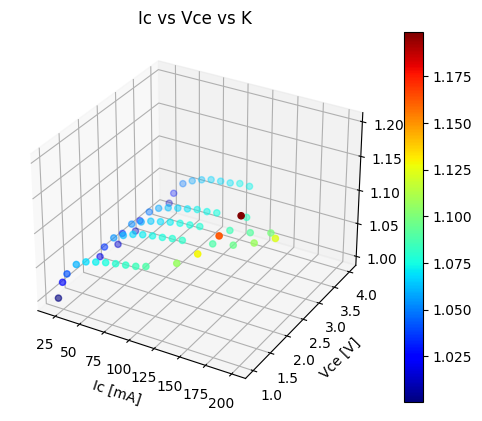

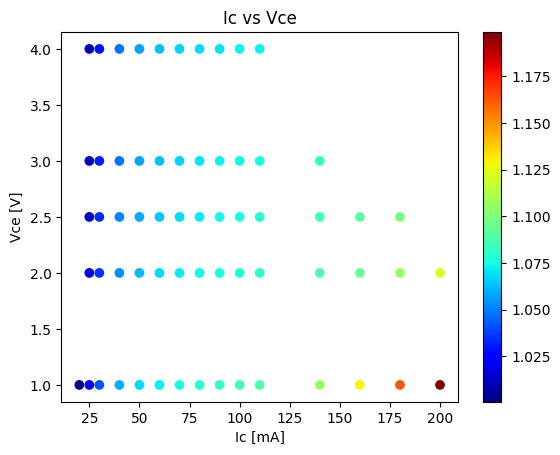

In [6]:
# Grafico de ic vs vce vs k. Queda en 3D y con mapa termico para K

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df['Ic'], df['Vce'], df['K'], c=df['K'], cmap=cm.jet)
plt.colorbar(sc)
ax.set_xlabel('Ic [mA]')
ax.set_ylabel('Vce [V]')
ax.set_zlabel('K')
plt.title('Ic vs Vce vs K')
plt.show()

# El mismo grafico pero que sea termico en funcion de Ic y Vce
fig = plt.figure()
ax = fig.add_subplot(111)
sc = ax.scatter(df['Ic'], df['Vce'], c=df['K'], cmap=cm.jet)
plt.colorbar(sc)
ax.set_xlabel('Ic [mA]')
ax.set_ylabel('Vce [V]')
plt.title('Ic vs Vce')
plt.show()



# Calculo con s- seleccionado

In [7]:
# Funcion que calcula todos los parametros necesarios

def calculos_total(f, S_11, S_12, S_21, S_22, Zo):

    
    #Calculo de estabilidad
    Delta = S_11*S_22 - S_12*S_21
    K = (1 - np.abs(S_11)**2 - np.abs(S_22)**2 + np.abs(Delta)**2)/(2*np.abs(S_12*S_21))
    
    if K < 1:
        print('No es estable')
    else:
        print('Es estable')
    
    # Calculo de coeficientes 
    B1 = 1 + np.abs(S_11)**2 - np.abs(S_22)**2 - np.abs(Delta)**2
    B2 = 1 + np.abs(S_22)**2 - np.abs(S_11)**2 - np.abs(Delta)**2
    C1 = S_11 - Delta*np.conj(S_22)
    C2 = S_22 - Delta*np.conj(S_11)
    
    C1_mod = np.abs(C1)
    C1_fase = np.angle(C1)
    C2_mod = np.abs(C2)
    C2_fase = np.angle(C2)
    
    # Calculo de reflexiones de entrada y salida
    Gamma_in_fase = C1_fase
    
    if B1 > 0:
        Gamma_in_mod = (B1 - np.sqrt(B1**2 - 4*C1_mod**2))/(2*C1_mod)
    else:
        Gamma_in_mod = (B1 + np.sqrt(B1**2 - 4*C1_mod**2))/(2*C1_mod)
        
    
    Gamma_in = Gamma_in_mod*np.exp(1j*Gamma_in_fase)
    
    
    Gamma_out_fase = C2_fase
    
    if B2 > 0:
        Gamma_out_mod = (B2 - np.sqrt(B2**2 - 4*C2_mod**2))/(2*C2_mod)
    else:
        Gamma_out_mod = (B2 + np.sqrt(B2**2 - 4*C2_mod**2))/(2*C2_mod)
        
    
    Gamma_out = Gamma_out_mod*np.exp(1j*Gamma_out_fase)
    
    Zin = Zo*(1 + Gamma_in)/(1 - Gamma_in)
    Zout = Zo*(1 + Gamma_out)/(1 - Gamma_out)
    
    Zin = np.round(Zin,4)
    Zout = np.round(Zout,4)
    Zs = np.round(np.conj(Zin),4)
    Zl = np.round(np.conj(Zout),4)
    K = np.round(K,4)

    
    return Zin, Zout, Zs, Zl, K
    

In [8]:
# Seleccion de Ic y Vce
IC_sel = 110/1000
Vce_sel = 2.5
f = 1.6e9

# Parametros S
dato = r'C:\Users\Jeremias\Documents\GitHub\TP2-Electronica-Analogica-III\Hoja de datos\BFP 450\Infineon-RFTransistor\SPAR\BFP450/BFP450_w_noise_'
str_model = dato+'VCE_'+str(Vce_sel)+'V_IC_'+str(IC_sel)+'A.s2p'

model = rf.Network(str_model)
S11 = model['1.6ghz'].s[0][0][0]
S12 = model['1.6ghz'].s[0][0][1]
S21 = model['1.6ghz'].s[0][1][0]
S22 = model['1.6ghz'].s[0][1][1]

print ('S11 = ' + str(S11))
print ('S12 = ' + str(S12))
print ('S21 = ' + str(S21))
print ('S22 = ' + str(S22))

valores = calculos_total(f, S11, S12, S21, S22, 50)
Zin = valores[0]
Zout = valores[1]
Zs = valores[2]
Zl = valores[3]
K = valores[4]

print('Zin =' + str(Zin) + ' Ohm')
print('Zout =' + str(Zout) + ' Ohm')
print('Zs =' + str(Zs) + ' Ohm')
print('Zl =' + str(Zl) + ' Ohm')
print('K =' + str(K))


S11 = (-0.6887813841901239+0.27968511721780415j)
S12 = (0.0329006355170892+0.05124800662046915j)
S21 = (2.0992062681698505+3.981498969443093j)
S22 = (-0.5099988830350469+0.10747362142872341j)
Es estable
Zin =(6.5753+5.7465j) Ohm
Zout =(25.0743-17.8172j) Ohm
Zs =(6.5753-5.7465j) Ohm
Zl =(25.0743+17.8172j) Ohm
K =1.0782


In [17]:
# Ganancia max de transconductancia
GTUmax = (np.abs(S21)/np.abs(S12)) * (K-np.sqrt(K**2-1))
GTUmax_dB = 10*np.log10(GTUmax)

print('GTUmax = ' + str(GTUmax))
print('GTUmax_dB = ' + str(GTUmax_dB) + ' dB')

GTUmax = 49.892972312254294
GTUmax_dB = 16.980393772676866 dB


### Calculo de impedancias de entrada

In [9]:
# Serie a paralelo
f = 1.6e9
Zo = 50

# Inductor en serie con resistencia a paralelo
Rs = np.real(Zin)
Xs = np.imag(Zin)

Rp = Rs*(1 + (Xs/Rs)**2)
Xp = Rs*Rp/Xs

print('Rs = ' + str(Rs) + ' Ohm')
print('Xs = ' + str(Xs) + ' Ohm')
print('Rp = ' + str(Rp) + ' Ohm')
print('Xp = ' + str(Xp) + ' Ohm')

# Tengo que anular Xl con un capacitor en paralelo 
Xc = Xp
Cp = 1/(2*np.pi*f*Xc)*1e12
Cp = np.round(Cp,4)

print('Xc = ' + str(Xc) + ' Ohm')
print('Cp = ' + str(Cp) + 'pF')

# Adaotador lambda/4
Zo_in = np.sqrt(Rp*Zo)
Zo_in = np.round(Zo_in,4)
print('Zo_in = ' + str(Zo_in) + ' Ohm')


Rs = 6.5753 Ohm
Xs = 5.7465 Ohm
Rp = 11.597468152023481 Ohm
Xp = 13.270135271904637 Ohm
Xc = 13.270135271904637 Ohm
Cp = 7.4959pF
Zo_in = 24.0806 Ohm


### Calculo de imp de salida

In [10]:
# Serie a paralelo
f = 1.6e9
Zo = 50

Rout = np.real(Zout)
Xout = np.imag(Zout) # Es un capacitor

Zo_out = np.sqrt(Rout*Zo)
Zo_out = np.round(Zo_out,4)
X_outC = np.abs(Zo_out**2/Xout)
X_outC = np.round(X_outC,4)

print('Rout = ' + str(Rout) + ' Ohm')
print('Xout = ' + str(Xout) + ' Ohm')
print('Zo_out = ' + str(Zo_out) + ' Ohm')
print('X_outC = ' + str(X_outC) + ' Ohm')

# Se agrega un capacitor a la salida del adaptador lambda/4 para que lo vea como una inductancia y se anule con Xout
# Desde Zout a la salida vemos z' = Zo_out**2/Xc 
# Xc = Zo_out**2/Xout

Cout = 1/(2*np.pi*f*X_outC)*1e12
Cout = np.round(Cout,4)

print('Cout = ' + str(Cout) + 'pF')



Rout = 25.0743 Ohm
Xout = -17.8172 Ohm
Zo_out = 35.4078 Ohm
X_outC = 70.3653 Ohm
Cout = 1.4136pF


### CAlculo de microtiras
##### Tendremos que utilizar las ecuaciones de Hammerstad y tener las caracterisiticas del pcb

In [11]:
# Funcion que calcula los parametros necesarios con Hammerstad y Jensen

def Hammerstad(epsilom, h, t, zo):
    
    A = zo/60*np.sqrt((epsilom + 1)/2) + (epsilom - 1)/(epsilom + 1)*(0.23 + 0.11/epsilom)
    B = 377*np.pi/(2*zo*np.sqrt(epsilom))

    # Para W/h <= 2
    W_h_1 = (8*np.exp(A)/(np.exp(2*A) - 2))
    W_h_2 = (2/np.pi*(B-1-np.log(2*B-1) + (epsilom - 1)/(2*epsilom)*(np.log(B-1) + 0.39 - 0.61/epsilom)))

   
   
    if W_h_1 <= 2:
        w_h = W_h_1
    else:
        w_h = W_h_2
        
    W = w_h*h
    
    # calculo de We
    if W/h >= (0.5*np.pi):
        We = W + (t/np.pi)*(1 + np.log(2*h/t))
    else:
        We = W + (t/np.pi)*(1 + np.log(4*np.pi*W/t))
        
    # Correccion de Er 
    if W/h >= 1:
        epsilom_eff = ((epsilom + 1)/2) + ((epsilom - 1)/2)*(1/(np.sqrt(1 + 12*h/W)))
    else:
        epsilom_eff = ((epsilom + 1)/2) + ((epsilom - 1)/2)*((1/(np.sqrt(1 + 12*h/W))) + 0.04*(1 - W/h)**2)
    
    # lamda real = 300 / f donde f es la frecuencia en MHz y nos da lambda en metros
    frecuencia = 1600
    lambda_real = 300/frecuencia
    lambda_eff = lambda_real/(np.sqrt(epsilom_eff))
    
    # beta in
    beta_in = 2*np.pi/lambda_eff # es el beta de la linea de transmision
    
            
    return A, B, W, We, epsilom_eff, lambda_eff, beta_in
    
    

In [12]:
# Caracteristicas de la pcb de FR4 de 2 capas
epsilom = 4
h = 1.44e-3
t = 0.04e-3

# Hammerstad y Jensen 

# Calculo de impedancia caracteristica para la linea de transmision
Zo50 = 50 

calculados_zo50 = Hammerstad(epsilom, h, t, Zo50)

print('A = ' + str(calculados_zo50[0]))
print('B = ' + str(calculados_zo50[1]))
print('W = ' + str(calculados_zo50[2]*1e3) + ' mm')
print('We = ' + str(calculados_zo50[3]*1e3) + ' mm')
print('Epsilom_eff = ' + str(calculados_zo50[4]))
print('Lambda_eff = ' + str(calculados_zo50[5]) + ' mm')
print('Beta_in = ' + str(calculados_zo50[6]) + ' rad/m')





A = 1.472115691736825
B = 5.921902152016759
W = 2.9564681074142656 mm
We = 3.0236527070852204 mm
Epsilom_eff = 3.073337699935324
Lambda_eff = 0.10695377807876696 mm
Beta_in = 58.74673545942701 rad/m


### Funcion para microtiras, capacitores

In [13]:
# Funcion que calcula los parametros necesarios con Hammerstad y Jensen

def Hammerstad_total(epsilom, h, t, zo):
    
    A = zo/60*np.sqrt((epsilom + 1)/2) + (epsilom - 1)/(epsilom + 1)*(0.23 + 0.11/epsilom)
    B = 377*np.pi/(2*zo*np.sqrt(epsilom))

    # Para W/h <= 2
    W_h_1 = (8*np.exp(A)/(np.exp(2*A) - 2))
    W_h_2 = (2/np.pi*(B-1-np.log(2*B-1) + (epsilom - 1)/(2*epsilom)*(np.log(B-1) + 0.39 - 0.61/epsilom)))

   
   
    if W_h_1 <= 2:
        w_h = W_h_1
    else:
        w_h = W_h_2
        
    W = w_h*h
    
    # calculo de We
    if W/h >= (0.5*np.pi):
        We = W + (t/np.pi)*(1 + np.log(2*h/t))
    else:
        We = W + (t/np.pi)*(1 + np.log(4*np.pi*W/t))
        
    # Correccion de Er 
    if W/h >= 1:
        epsilom_eff = ((epsilom + 1)/2) + ((epsilom - 1)/2)*(1/(np.sqrt(1 + 12*h/W)))
    else:
        epsilom_eff = ((epsilom + 1)/2) + ((epsilom - 1)/2)*((1/(np.sqrt(1 + 12*h/W))) + 0.04*(1 - W/h)**2)
    
    # lamda real = 300 / f donde f es la frecuencia en MHz y nos da lambda en metros
    frecuencia = 1600
    lambda_real = 300/frecuencia
    lambda_eff = lambda_real/(np.sqrt(epsilom_eff))
    
    # beta es la constante de fase de la linea de transmision
    beta = 2*np.pi/lambda_eff 
    
    # longitud de la microtira en metros
    l = lambda_eff/4
    
    # Angulo de fase electrico
    Eeff = beta*l*180/np.pi

    
    return A, B, W, We, epsilom_eff, lambda_eff, beta, l, Eeff

In [14]:
# Funcion que calcula los parametros necesarios con Hammerstad y Jensen
def Hammerstad_capacitor(epsilom, h, t, zo, Cp):
    
    f = 1.6e9
    Xc = 1/(2*np.pi*f*Cp)
    
    A = zo/60*np.sqrt((epsilom + 1)/2) + (epsilom - 1)/(epsilom + 1)*(0.23 + 0.11/epsilom)
    B = 377*np.pi/(2*zo*np.sqrt(epsilom))

    # Para W/h <= 2
    W_h_1 = (8*np.exp(A)/(np.exp(2*A) - 2))
    W_h_2 = (2/np.pi*(B-1-np.log(2*B-1) + (epsilom - 1)/(2*epsilom)*(np.log(B-1) + 0.39 - 0.61/epsilom)))

   
   
    if W_h_1 <= 2:
        w_h = W_h_1
    else:
        w_h = W_h_2
        
    W = w_h*h
    
    # calculo de We
    if W/h >= (0.5*np.pi):
        We = W + (t/np.pi)*(1 + np.log(2*h/t))
    else:
        We = W + (t/np.pi)*(1 + np.log(4*np.pi*W/t))
        
    # Correccion de Er 
    if W/h >= 1:
        epsilom_eff = ((epsilom + 1)/2) + ((epsilom - 1)/2)*(1/(np.sqrt(1 + 12*h/W)))
    else:
        epsilom_eff = ((epsilom + 1)/2) + ((epsilom - 1)/2)*((1/(np.sqrt(1 + 12*h/W))) + 0.04*(1 - W/h)**2)
    
    # lamda real = 300 / f donde f es la frecuencia en MHz y nos da lambda en metros
    frecuencia = f * 1e-6
    lambda_real = 300/frecuencia
    lambda_eff = lambda_real/(np.sqrt(epsilom_eff))
    
    # beta es la constante de fase de la linea de transmision
    beta = 2*np.pi/lambda_eff 
    
    # longitud de la microtira en metros, para este caso se utiliza una formula distinta, la cual es el atan(Zo/Xc)/beta
    l = np.arctan(zo/Xc)/beta
    
    # Angulo de fase electrico
    Eeff = beta*l*180/np.pi

    
    return A, B, W, We, epsilom_eff, lambda_eff, beta, l, Eeff

In [15]:
epsilom = 4
h = 1.44e-3
t = 0.04e-3

# Adaptador de entrada lamda/4
#Rs = 6.5753 Ohm
#Xs = 5.7465 Ohm
#Rp = 11.597468152023481 Ohm
#Xp= 13.270135271904#637 Ohm
#Xc = 13.270#135271904637 Ohm
#Cp = 7.4959pF
#Zo_in = 24.0806 Ohm


#Calculo de adaptador lamda/4 a la entra
Zoin = 24.0806
Adaptador_entrada = Hammerstad_total(epsilom, h, t, Zoin)

print('A = ' + str(Adaptador_entrada[0]))
print('B = ' + str(Adaptador_entrada[1]))
print('W = ' + str(Adaptador_entrada[2]*1e3) + ' mm')
print('We = ' + str(Adaptador_entrada[3]*1e3) + ' mm')
print('Epsilom_eff = ' + str(Adaptador_entrada[4]))
print('Lambda_eff = ' + str(Adaptador_entrada[5]) + ' mm')
print('Beta = ' + str(Adaptador_entrada[6]) + ' rad/m')
print('l = ' + str(Adaptador_entrada[7]*1e3) + ' mm')
print('Eeff = ' + str(Adaptador_entrada[8]) + ' grados')


Zcap_in = 50
# Capacitor de microtiras
Cp = 7.4959e-12
Capacitor_microtiras = Hammerstad_capacitor(epsilom, h, t, Zcap_in, Cp)

print("\n Capacitor de microtiras")
print('A = ' + str(Capacitor_microtiras[0]))
print('B = ' + str(Capacitor_microtiras[1]))
print('W = ' + str(Capacitor_microtiras[2]*1e3) + ' mm')
print('We = ' + str(Capacitor_microtiras[3]*1e3) + ' mm')
print('Epsilom_eff = ' + str(Capacitor_microtiras[4]))
print('Lambda_eff = ' + str(Capacitor_microtiras[5]) + ' mm')
print('Beta = ' + str(Capacitor_microtiras[6]) + ' rad/m')
print('l = ' + str(Capacitor_microtiras[7]*1e3) + ' mm')
print('Eeff = ' + str(Capacitor_microtiras[8]) + ' grados')


A = 0.7890795285287556
B = 12.296002076395023
W = 8.372815655391792 mm
We = 8.440000255062747 mm
Epsilom_eff = 3.3569579333357096
Lambda_eff = 0.10233597285576594 mm
Beta = 61.39762130404735 rad/m
l = 25.583993213941486 mm
Eeff = 90.0 grados

 Capacitor de microtiras
A = 1.472115691736825
B = 5.921902152016759
W = 2.9564681074142656 mm
We = 3.0236527070852204 mm
Epsilom_eff = 3.073337699935324
Lambda_eff = 0.10695377807876696 mm
Beta = 58.74673545942701 rad/m
l = 22.32249610295028 mm
Eeff = 75.13618257733589 grados


In [16]:
epsilom = 4
h = 1.44e-3
t = 0.04e-3

# Adaptador de salida lambda/4da
#Rout = 25.0743 Ohm#(resistencia serie)
#Xout = -17.8172 Ohm#(capacitor serie)
#Zo_out = 35.4078 Ohm#()
#X_outC = 70.3653 Ohm#()
#Cout = 1.4136pF#(capacitor de salida, para cancelar capacitor serie) 
Zinout = 35.4078
Adaptador_salida = Hammerstad_total(epsilom, h, t, Zinout)

print('A = ' + str(Adaptador_salida[0]))
print('B = ' + str(Adaptador_salida[1]))
print('W = ' + str(Adaptador_salida[2]*1e3) + ' mm')
print('We = ' + str(Adaptador_salida[3]*1e3) + ' mm')
print('Epsilom_eff = ' + str(Adaptador_salida[4]))
print('Lambda_eff = ' + str(Adaptador_salida[5]) + ' mm')
print('Beta = ' + str(Adaptador_salida[6]) + ' rad/m')
print('l = ' + str(Adaptador_salida[7]*1e3) + ' mm')
print('Eeff = ' + str(Adaptador_salida[8]) + ' grados')

#Calculo de stub, capacitor de salida
C_out = 1.4136e-12 #capacitor de salida
Zout_50 = 50 #impedancia caracteristica de la linea de transmision
Stub_salida = Hammerstad_capacitor(epsilom, h, t, Zout_50, C_out)

print('\nA = ' + str(Stub_salida[0]))
print('B = ' + str(Stub_salida[1]))
print('W = ' + str(Stub_salida[2]*1e3) + ' mm')
print('We = ' + str(Stub_salida[3]*1e3) + ' mm')
print('Epsilom_eff = ' + str(Stub_salida[4]))
print('Lambda_eff = ' + str(Stub_salida[5]) + ' mm')
print('Beta = ' + str(Stub_salida[6]) + ' rad/m')
print('l = ' + str(Stub_salida[7]*1e3) + ' mm')
print('Eeff = ' + str(Stub_salida[8]) + ' grados')


A = 1.087577457797583
B = 8.36242600785245
W = 4.9915094674561855 mm
We = 5.05869406712714 mm
Epsilom_eff = 3.210121043071693
Lambda_eff = 0.10465032171991458 mm
Beta = 60.03980880245989 rad/m
l = 26.162580429978643 mm
Eeff = 90.0 grados

A = 1.472115691736825
B = 5.921902152016759
W = 2.9564681074142656 mm
We = 3.0236527070852204 mm
Epsilom_eff = 3.073337699935324
Lambda_eff = 0.10695377807876696 mm
Beta = 58.74673545942701 rad/m
l = 10.515875642465874 mm
Eeff = 35.39580648099868 grados
